## Business Understanding

A company works with multiple vendors to purchase products that are later sold to customers. To remain profitable, the company must manage inventory efficiently, control purchase costs, and collaborate with reliable vendors.

This project uses multiple datasets:
- begin_inventory
- end_inventory
- purchase_prices
- purchases
- sales
- vendor_invoice

Using these datasets, the analysis focuses on evaluating vendor performance, inventory behavior, cost versus price, profitability, vendor dependency, purchasing patterns, and inventory turnover. The objective is to generate data-driven insights that help improve purchasing decisions, pricing strategies, and overall inventory management.

#### Data Understanding

In [1]:
# load essential libraries

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load files

begin_inventory = pd.read_csv('begin_inventory.csv')
end_inventory = pd.read_csv('end_inventory.csv')
purchase_prices = pd.read_csv('purchase_prices.csv')
purchases = pd.read_csv('purchases.csv')
sales = pd.read_csv('sales.csv')
vendor_invoice = pd.read_csv('vendor_invoice.csv')

In [4]:
# checking data
print('--------begin_inventory--------')
print(begin_inventory.head(3),'\n')
print('--------end_inventory--------')
print(end_inventory.head(3),'\n')
print('--------purchase_prices--------')
print(purchase_prices.head(3),'\n')
print('--------purchases--------')
print(purchases.head(3),'\n')
print('--------sales--------')
print(sales.head(3),'\n')
print('--------vendor_invoice--------')
print(vendor_invoice.head(3),'\n')

--------begin_inventory--------
         InventoryId  Store          City  Brand                  Description  \
0  1_HARDERSFIELD_58      1  HARDERSFIELD     58  Gekkeikan Black & Gold Sake   
1  1_HARDERSFIELD_60      1  HARDERSFIELD     60       Canadian Club 1858 VAP   
2  1_HARDERSFIELD_62      1  HARDERSFIELD     62     Herradura Silver Tequila   

    Size  onHand  Price   startDate  
0  750mL       8  12.99  2024-01-01  
1  750mL       7  10.99  2024-01-01  
2  750mL       6  36.99  2024-01-01   

--------end_inventory--------
         InventoryId  Store          City  Brand                  Description  \
0  1_HARDERSFIELD_58      1  HARDERSFIELD     58  Gekkeikan Black & Gold Sake   
1  1_HARDERSFIELD_62      1  HARDERSFIELD     62     Herradura Silver Tequila   
2  1_HARDERSFIELD_63      1  HARDERSFIELD     63   Herradura Reposado Tequila   

    Size  onHand  Price     endDate  
0  750mL      11  12.99  2024-12-31  
1  750mL       7  36.99  2024-12-31  
2  750mL       7  38

In [5]:
# understanding Dataset sizes
print('begin_inventory dataset:',begin_inventory.shape,'\n')
print('end_inventory dataset:',end_inventory.shape,'\n')
print('purchase_prices dataset:',purchase_prices.shape,'\n')
print('purchases dataset:',purchases.shape,'\n')
print('sales dataset:',sales.shape,'\n')
print('vendor_invoice dataset:',vendor_invoice.shape,'\n')

begin_inventory dataset: (206529, 9) 

end_inventory dataset: (224489, 9) 

purchase_prices dataset: (12261, 9) 

purchases dataset: (2372474, 16) 

sales dataset: (12825363, 14) 

vendor_invoice dataset: (5543, 10) 



#### Data Cleaning

In [6]:
# checking for Missing Values
print('--------begin_inventory--------')
print(begin_inventory.isnull().sum(),'\n')
print('--------end_inventory--------')
print(end_inventory.isnull().sum(),'\n')
print('--------purchase_prices--------')
print(purchase_prices.isnull().sum(),'\n')
print('--------purchases--------')
print(purchases.isnull().sum(),'\n')
print('--------sales--------')
print(sales.isnull().sum(),'\n')
print('--------vendor_invoice--------')
print(vendor_invoice.isnull().sum(),'\n')

--------begin_inventory--------
InventoryId    0
Store          0
City           0
Brand          0
Description    0
Size           0
onHand         0
Price          0
startDate      0
dtype: int64 

--------end_inventory--------
InventoryId       0
Store             0
City           1284
Brand             0
Description       0
Size              0
onHand            0
Price             0
endDate           0
dtype: int64 

--------purchase_prices--------
Brand             0
Description       1
Price             0
Size              1
Volume            1
Classification    0
PurchasePrice     0
VendorNumber      0
VendorName        0
dtype: int64 

--------purchases--------
InventoryId       0
Store             0
Brand             0
Description       0
Size              3
VendorNumber      0
VendorName        0
PONumber          0
PODate            0
ReceivingDate     0
InvoiceDate       0
PayDate           0
PurchasePrice     0
Quantity          0
Dollars           0
Classification    0
dt

-  The `end_inventory` dataframe has 1284 missing values in the 'City' column which we can fill using 'Store' mapping. But the column 'City' is not really required for our vendor analysis, thus we can drop this column.
-  the `purchase_prices` dataframe has 1 missing value in fileds -> 'Describtion', 'Size' & 'Volume'. Thus we can drop this single row.
-  Similarly, the `purchases` dataframe has 3 missing values in the 'Size' field. These rows can be filled using 'Description' but here we can just drop these rows as it won't affect our vendor performance.
-  The `vendor_invoice` dataframe has 5169 missing values under column 'Approval', since this seems above 40% missing values of the total size, thus we should drop this column completely.

In [7]:
# drop unnecessary rows/columns
end_inventory.drop(columns=['City'], inplace = True)
begin_inventory.drop(columns = ['City'], inplace = True)
purchase_prices.dropna(inplace = True)
purchases.dropna(subset =['Size'], inplace = True)
vendor_invoice.drop(columns=['Approval'], inplace = True)

In [8]:
# check datatypes
begin_inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206529 entries, 0 to 206528
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InventoryId  206529 non-null  object 
 1   Store        206529 non-null  int64  
 2   Brand        206529 non-null  int64  
 3   Description  206529 non-null  object 
 4   Size         206529 non-null  object 
 5   onHand       206529 non-null  int64  
 6   Price        206529 non-null  float64
 7   startDate    206529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 12.6+ MB


In [9]:
end_inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224489 entries, 0 to 224488
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InventoryId  224489 non-null  object 
 1   Store        224489 non-null  int64  
 2   Brand        224489 non-null  int64  
 3   Description  224489 non-null  object 
 4   Size         224489 non-null  object 
 5   onHand       224489 non-null  int64  
 6   Price        224489 non-null  float64
 7   endDate      224489 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 13.7+ MB


In [10]:
purchase_prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12260 entries, 0 to 12260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           12260 non-null  int64  
 1   Description     12260 non-null  object 
 2   Price           12260 non-null  float64
 3   Size            12260 non-null  object 
 4   Volume          12260 non-null  object 
 5   Classification  12260 non-null  int64  
 6   PurchasePrice   12260 non-null  float64
 7   VendorNumber    12260 non-null  int64  
 8   VendorName      12260 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 957.8+ KB


In [11]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2372471 entries, 0 to 2372473
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   InventoryId     object 
 1   Store           int64  
 2   Brand           int64  
 3   Description     object 
 4   Size            object 
 5   VendorNumber    int64  
 6   VendorName      object 
 7   PONumber        int64  
 8   PODate          object 
 9   ReceivingDate   object 
 10  InvoiceDate     object 
 11  PayDate         object 
 12  PurchasePrice   float64
 13  Quantity        int64  
 14  Dollars         float64
 15  Classification  int64  
dtypes: float64(2), int64(6), object(8)
memory usage: 307.7+ MB


In [12]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12825363 entries, 0 to 12825362
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   InventoryId     object 
 1   Store           int64  
 2   Brand           int64  
 3   Description     object 
 4   Size            object 
 5   SalesQuantity   int64  
 6   SalesDollars    float64
 7   SalesPrice      float64
 8   SalesDate       object 
 9   Volume          float64
 10  Classification  int64  
 11  ExciseTax       float64
 12  VendorNo        int64  
 13  VendorName      object 
dtypes: float64(4), int64(5), object(5)
memory usage: 1.3+ GB


In [13]:
vendor_invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5543 entries, 0 to 5542
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   VendorNumber  5543 non-null   int64  
 1   VendorName    5543 non-null   object 
 2   InvoiceDate   5543 non-null   object 
 3   PONumber      5543 non-null   int64  
 4   PODate        5543 non-null   object 
 5   PayDate       5543 non-null   object 
 6   Quantity      5543 non-null   int64  
 7   Dollars       5543 non-null   float64
 8   Freight       5543 non-null   float64
dtypes: float64(2), int64(3), object(4)
memory usage: 389.9+ KB


In [14]:
purchase_prices[purchase_prices['Volume']=='Unknown']

,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
542,2993,Angostura Bitters,7.49,Unknown,Unknown,1,5.39,5895,"Mizkan Americas, Inc."
5921,9908,Tito's Copper Mug 2 Pack,21.01,Unknown,Unknown,1,16.15,4425,MARTIGNETTI COMPANIES
8795,8992,Group 92,1.99,Unknown,Unknown,1,1.43,1703,ALISA CARR BEVERAGES
10009,90590,Overture Champagne 2Glass Pk,19.95,Unknown,Unknown,2,13.12,4425,MARTIGNETTI COMPANIES


In [15]:
purchase_prices[['Size','Volume']] = purchase_prices[['Size','Volume']].replace('Unknown',np.nan)

In [16]:
# assign proper datatypes to certain columns
begin_inventory['startDate'] = pd.to_datetime(begin_inventory['startDate'])

end_inventory['endDate'] = pd.to_datetime(end_inventory['endDate'])

purchase_prices['Volume'] = purchase_prices['Volume'].astype(float)

purchases['PODate'] = pd.to_datetime(purchases['PODate'])
purchases['ReceivingDate'] = pd.to_datetime(purchases['ReceivingDate'])
purchases['InvoiceDate'] = pd.to_datetime(purchases['InvoiceDate'])
purchases['PayDate'] = pd.to_datetime(purchases['PayDate'])

sales['SalesDate'] = pd.to_datetime(sales['SalesDate'])

vendor_invoice['InvoiceDate'] = pd.to_datetime(vendor_invoice['InvoiceDate'])
vendor_invoice['PODate'] = pd.to_datetime(vendor_invoice['PODate'])
vendor_invoice['PayDate'] = pd.to_datetime(vendor_invoice['PayDate'])

In [17]:
# check numerical summary
begin_inventory.describe()

,Store,Brand,onHand,Price,startDate
count,206529.000000,206529.000000,206529.000000,206529.000000,206529
mean,42.122457,13761.482320,20.429455,22.253910,2024-01-01 00:00:00
min,1.000000,58.000000,0.000000,0.000000,2024-01-01 00:00:00
25%,22.000000,3746.000000,7.000000,9.990000,2024-01-01 00:00:00
50%,42.000000,8010.000000,12.000000,14.990000,2024-01-01 00:00:00
75%,64.000000,22143.000000,21.000000,21.990000,2024-01-01 00:00:00
max,79.000000,90090.000000,1251.000000,13999.900000,2024-01-01 00:00:00
std,23.191393,13059.429355,31.467342,70.178964,NaN


In [18]:
begin_inventory[begin_inventory['Price']==0]

,InventoryId,Store,Brand,Description,Size,onHand,Price,startDate
36829,15_WANBORNE_19138,15,19138,Gerard Bertrand Organic Rose,750mL,0,0.0,2024-01-01
175458,69_MOUNTMEND_19138,69,19138,Gerard Bertrand Organic Rose,750mL,2,0.0,2024-01-01


In [19]:
begin_inventory = begin_inventory[begin_inventory['Price']>0]

In [20]:
end_inventory.describe()

,Store,Brand,onHand,Price,endDate
count,224489.000000,224489.000000,224489.000000,224489.000000,224489
mean,43.505740,14356.370513,21.763988,23.585583,2024-12-31 00:00:00.000000256
min,1.000000,58.000000,0.000000,0.490000,2024-12-31 00:00:00
25%,23.000000,3798.000000,7.000000,9.990000,2024-12-31 00:00:00
50%,44.000000,8259.000000,12.000000,14.990000,2024-12-31 00:00:00
75%,66.000000,23965.000000,22.000000,23.490000,2024-12-31 00:00:00
max,81.000000,90631.000000,3676.000000,13999.900000,2024-12-31 00:00:00
std,23.326415,13118.467851,37.233576,79.202775,NaN


In [21]:
purchase_prices.describe(include = 'all')

,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
count,12260.000000,12260,12260.000000,12256,12256.000000,12260.000000,12260.000000,12260.000000,12260
unique,NaN,11114,NaN,55,NaN,NaN,NaN,NaN,136
top,NaN,Jagermeister Liqueur,NaN,750mL,NaN,NaN,NaN,NaN,MARTIGNETTI COMPANIES
freq,NaN,7,NaN,9823,NaN,NaN,NaN,NaN,1631
mean,17990.191680,NaN,38.643392,NaN,842.921467,1.709054,26.489467,10815.704731,NaN
std,12528.395592,NaN,206.159284,NaN,679.529628,0.454217,156.189257,19008.228360,NaN
min,58.000000,NaN,0.000000,NaN,20.000000,1.000000,0.000000,2.000000,NaN
25%,5991.500000,NaN,10.990000,NaN,750.000000,1.000000,6.890000,3960.000000,NaN
50%,18789.000000,NaN,15.990000,NaN,750.000000,2.000000,10.645000,7153.000000,NaN
75%,25117.250000,NaN,29.990000,NaN,750.000000,2.000000,20.130000,9552.000000,NaN


In [22]:
purchase_prices[purchase_prices['PurchasePrice']==0]

,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
10803,2166,The Macallan Double Cask 12,0.0,750mL,750.0,1,0.0,2561,EDRINGTON AMERICAS


-  To get the 'PurchasePrice' for this 'Brand' we need to extract unit price from vendor_invoice table and then get the median of those unit costs.

In [23]:
# extract UnitPrice form vendor_invoice
vendor_invoice['UnitPrice'] = vendor_invoice['Dollars']/vendor_invoice['Quantity']

In [24]:
# checks
vendor_invoice.loc[vendor_invoice['VendorNumber']==2561, ['PONumber','Dollars','Quantity','UnitPrice']].head()

,PONumber,Dollars,Quantity,UnitPrice
23,8175,5645.24,136,41.509118
115,8239,29875.70,980,30.485408
212,8361,11724.18,433,27.076628
306,8486,20849.80,689,30.260958
407,8591,42239.46,765,55.214980


In [25]:
median_unit_price = vendor_invoice.loc[vendor_invoice['VendorNumber']==2561, 'UnitPrice'].median()
purchase_prices.loc[purchase_prices['PurchasePrice']==0, 'PurchasePrice'] = median_unit_price

In [26]:
purchase_prices[purchase_prices['Price']==0]

,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
10803,2166,The Macallan Double Cask 12,0.0,750mL,750.0,1,29.972048,2561,EDRINGTON AMERICAS


In [27]:
median_sales_price = sales.loc[(sales['Brand']== 2166) & (sales['SalesPrice']>0), 'SalesPrice'].median()
purchase_prices.loc[(purchase_prices['Brand']==2166) & (purchase_prices['Price']==0), 'Price'] = median_sales_price

In [28]:
purchases.describe()

,Store,Brand,VendorNumber,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
count,2.372471e+06,2.372471e+06,2.372471e+06,2.372471e+06,2372471,2372471,2372471,2372471,2.372471e+06,2.372471e+06,2.372471e+06,2.372471e+06
mean,4.465134e+01,1.241865e+04,6.886430e+03,1.104094e+04,2024-07-04 13:34:15.727551744,2024-07-12 04:28:07.421426432,2024-07-21 01:24:38.415540736,2024-08-25 17:13:19.285638400,1.205002e+01,1.415586e+01,1.356816e+02,1.443520e+00
min,1.000000e+00,5.800000e+01,2.000000e+00,8.106000e+03,2023-12-20 00:00:00,2024-01-01 00:00:00,2024-01-04 00:00:00,2024-02-04 00:00:00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
25%,2.500000e+01,3.639000e+03,3.252000e+03,9.761000e+03,2024-04-12 00:00:00,2024-04-20 00:00:00,2024-04-29 00:00:00,2024-06-02 00:00:00,6.120000e+00,6.000000e+00,4.926000e+01,1.000000e+00
50%,4.800000e+01,6.523000e+03,4.425000e+03,1.110300e+04,2024-07-07 00:00:00,2024-07-15 00:00:00,2024-07-25 00:00:00,2024-08-29 00:00:00,9.220000e+00,1.000000e+01,8.393000e+01,1.000000e+00
75%,6.700000e+01,1.887700e+04,9.552000e+03,1.239700e+04,2024-09-30 00:00:00,2024-10-07 00:00:00,2024-10-17 00:00:00,2024-11-24 00:00:00,1.449000e+01,1.200000e+01,1.405200e+02,2.000000e+00
max,8.100000e+01,9.063100e+04,2.013590e+05,1.366100e+04,2024-12-23 00:00:00,2024-12-31 00:00:00,2025-01-10 00:00:00,2025-02-19 00:00:00,5.681810e+03,3.816000e+03,5.017570e+04,2.000000e+00
std,2.351246e+01,1.255728e+04,8.066697e+03,1.565341e+03,NaN,NaN,NaN,NaN,1.794504e+01,2.344617e+01,2.816651e+02,4.967999e-01


-  As we can see there are rows where PurchasePrice is 0, thus we can get the value from purchase_prices dataset and also recalculate 'Dollars' column.

In [29]:
purchases.loc[(purchases['PurchasePrice']==0) | (purchases['Dollars']==0), 'Brand' ].unique()

array([2166], dtype=int64)

In [30]:
purchase_price = purchase_prices.loc[purchase_prices['Brand']==2166, 'PurchasePrice'].iloc[0]
purchase_price

29.972048154190222

In [31]:
purchases.loc[(purchases['Brand'] == 2166) & (purchases['PurchasePrice'] == 0),'PurchasePrice'] = purchase_price

In [32]:
purchases['Dollars'] = purchases['PurchasePrice'] * purchases['Quantity']

In [33]:
sales.describe()

,Store,Brand,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo
count,1.282536e+07,1.282536e+07,1.282536e+07,1.282536e+07,1.282536e+07,12825363,1.282536e+07,1.282536e+07,1.282536e+07,1.282536e+07
mean,4.389572e+01,1.215460e+04,2.566623e+00,3.524758e+01,1.569027e+01,2024-07-11 17:15:56.576718848,9.394389e+02,1.413892e+00,1.479431e+00,7.125907e+03
min,1.000000e+00,5.800000e+01,1.000000e+00,0.000000e+00,0.000000e+00,2024-01-01 00:00:00,5.000000e+01,1.000000e+00,1.000000e-02,2.000000e+00
25%,2.300000e+01,3.663000e+03,1.000000e+00,1.099000e+01,8.990000e+00,2024-04-15 00:00:00,7.500000e+02,1.000000e+00,2.100000e-01,3.252000e+03
50%,4.700000e+01,6.349000e+03,1.000000e+00,1.899000e+01,1.299000e+01,2024-07-15 00:00:00,7.500000e+02,1.000000e+00,7.500000e-01,4.692000e+03
75%,6.600000e+01,1.795400e+04,2.000000e+00,3.499000e+01,1.899000e+01,2024-10-09 00:00:00,1.000000e+03,2.000000e+00,1.570000e+00,9.552000e+03
max,8.100000e+01,9.063100e+04,1.231000e+03,2.606114e+04,5.799990e+03,2024-12-31 00:00:00,2.000000e+04,2.000000e+00,1.260520e+03,2.013590e+05
std,2.353947e+01,1.236843e+04,4.551810e+00,8.835689e+01,1.512728e+01,NaN,6.993202e+02,4.925295e-01,4.736633e+00,8.742565e+03


-  Some sales records have zero selling price thus we need to fix them by imputing the median price of the same product from some other valid sales records of different store selling the same brand, this will give us store consistent pricing behaviour.

In [34]:
# first lets get unique brands with 0 selling price
bad_brands = sales.loc[sales['SalesPrice']==0, 'Brand'].unique()

In [35]:
for b in bad_brands:
    median_price = sales.loc[(sales['Brand']==b) & (sales['SalesPrice']>0), 'SalesPrice'].median()
    sales.loc[(sales['Brand'] == b) & (sales['SalesPrice']==0), 'SalesPrice'] = median_price

In [36]:
sales['SalesDollars'] = sales['SalesPrice']* sales['SalesQuantity']

In [37]:
sales[sales['SalesPrice']==0].shape

(0, 14)

In [38]:
vendor_invoice.describe()

,VendorNumber,InvoiceDate,PONumber,PODate,PayDate,Quantity,Dollars,Freight,UnitPrice
count,5543.00000,5543,5543.000000,5543,5543,5543.000000,5.543000e+03,5543.000000,5543.000000
mean,20662.75212,2024-07-10 18:59:25.578206464,10889.419087,2024-06-24 08:48:08.832761856,2024-08-15 06:14:05.607072,6058.880931,5.807338e+04,295.954301,12.378382
min,2.00000,2024-01-04 00:00:00,8106.000000,2023-12-20 00:00:00,2024-02-04 00:00:00,1.000000,4.140000e+00,0.020000,1.095443
25%,3089.00000,2024-04-11 00:00:00,9503.500000,2024-03-24 12:00:00,2024-05-16 00:00:00,83.000000,9.678100e+02,5.020000,7.745602
50%,7240.00000,2024-07-11 00:00:00,10890.000000,2024-06-25 00:00:00,2024-08-15 00:00:00,423.000000,4.765450e+03,24.730000,10.060000
75%,10754.00000,2024-10-09 00:00:00,12275.500000,2024-09-23 00:00:00,2024-11-14 00:00:00,5100.500000,4.458718e+04,229.660000,14.560094
max,201359.00000,2025-01-10 00:00:00,13661.000000,2024-12-23 00:00:00,2025-02-19 00:00:00,141660.000000,1.660436e+06,8468.220000,183.951600
std,34582.15841,NaN,1600.859969,NaN,NaN,14453.338164,1.402340e+05,713.585093,8.139648


In [39]:
# checking for duplicates
begin_inventory.duplicated().sum()

0

In [40]:
end_inventory.duplicated().sum()

0

In [41]:
purchase_prices.duplicated().sum()

0

In [42]:
vendor_invoice.duplicated().sum()

0

In [43]:
sales.duplicated().sum()

0

In [44]:
purchases.duplicated().sum()

0

In [45]:
# now we save these cleaned datasets
begin_inventory.to_csv("begin_inventory_clean.csv", index = False)
end_inventory.to_csv("end_inventory_clean.csv", index=False)
purchase_prices.to_csv("purchase_prices_clean.csv", index=False)
purchases.to_csv("purchases_clean.csv", index=False)
sales.to_csv("sales_clean.csv", index=False)
vendor_invoice.to_csv("vendor_invoice_clean.csv", index=False)

-----------------------------------------------

In [46]:
# create a purchase based summary df
purchase_summary = (purchases.groupby(['VendorNumber','VendorName','Brand','Description'], as_index = False)
                        .agg(
                            TotalPurchaseQuantity = ('Quantity', 'sum'),
                            TotalPurchaseDollars = ('Dollars', 'sum'),
                            AvgPurchasePrice = ('PurchasePrice','mean'),
                            PurchaseFrequency = ('PONumber','nunique')))
purchase_summary.head()

,VendorNumber,VendorName,Brand,Description,TotalPurchaseQuantity,TotalPurchaseDollars,AvgPurchasePrice,PurchaseFrequency
0,2,"IRA GOLDMAN AND WILLIAMS, LLP",90085,Ch Lilian 09 Ladouys St Este,8,190.88,23.86,3
1,2,"IRA GOLDMAN AND WILLIAMS, LLP",90609,Flavor Essence Variety 5 Pak,320,5440.00,17.00,1
2,54,AAPER ALCOHOL & CHEMICAL CO,990,Ethyl Alcohol 200 Proof,1,105.07,105.07,1
3,60,ADAMBA IMPORTS INTL INC,771,Bak's Krupnik Honey Liqueur,39,446.16,11.44,4
4,60,ADAMBA IMPORTS INTL INC,3401,Vesica Vodka,6,66.60,11.10,1


In [47]:
purchase_summary.shape

(10692, 8)

In [48]:
# create sales summary table
sales_summary = (sales.groupby(['VendorNo','VendorName','Brand','Description'], as_index = False).agg(
                                    TotalSalesQuantity = ('SalesQuantity', 'sum'),
                                    TotalSalesDollars = ('SalesDollars', 'sum'),
                                    AvgSalesPrice = ('SalesPrice','mean')))
sales_summary.head()

,VendorNo,VendorName,Brand,Description,TotalSalesQuantity,TotalSalesDollars,AvgSalesPrice
0,2,"IRA GOLDMAN AND WILLIAMS, LLP",90085,Ch Lilian 09 Ladouys St Este,18,665.82,36.990000
1,2,"IRA GOLDMAN AND WILLIAMS, LLP",90609,Flavor Essence Variety 5 Pak,24,599.76,24.990000
2,60,ADAMBA IMPORTS INTL INC,771,Bak's Krupnik Honey Liqueur,47,704.53,14.990000
3,60,ADAMBA IMPORTS INTL INC,3979,Vesica Potato Vodka,3931,66871.69,17.020216
4,105,ALTAMAR BRANDS LLC,2529,Right Gin,12,359.88,29.990000


In [49]:
# rename VendorNo to VendorNumber 
sales_summary = sales_summary.rename(columns = {'VendorNo': 'VendorNumber'})

In [50]:
sales_summary.shape

(11272, 7)

In [51]:
# get total inventory at the beginning
begin_inventory_summary = begin_inventory.groupby(['Brand'], as_index = False).agg(
                                                                                BeginInventoryQty = ('onHand','sum'))

In [52]:
# get total inventory at the end
end_inventory_summary = end_inventory.groupby(['Brand'], as_index = False).agg(
                                                                                EndInventoryQty = ('onHand','sum'))

In [53]:
# merge both
inventory_summary = begin_inventory_summary.merge(end_inventory_summary, on='Brand', how= 'outer')

In [54]:
inventory_summary.head()

,Brand,BeginInventoryQty,EndInventoryQty
0,58,281.0,385.0
1,60,288.0,146.0
2,61,12.0,12.0
3,62,384.0,459.0
4,63,365.0,442.0


In [55]:
inventory_summary.shape

(10759, 3)

In [56]:
inventory_summary.isna().sum()

Brand                   0
BeginInventoryQty    2666
EndInventoryQty      1106
dtype: int64

-  This is expected as some Brand exist only at the beggining and some Brands exist only at the end as some maybe be added in the middle of the year or some could have been discontinued in the middle etc.

In [57]:
# merge sales and purchase summary tables
summary_df = purchase_summary.merge(sales_summary, on= ['VendorNumber','VendorName', 'Brand','Description'], how='outer')

In [58]:
summary_df = summary_df.merge(inventory_summary, on = 'Brand', how='left')

In [59]:
# fill the missing values for some Brands
summary_df['BeginInventoryQty'] = summary_df['BeginInventoryQty'].fillna(0)
summary_df['EndInventoryQty'] = summary_df['EndInventoryQty'].fillna(0)

In [60]:
summary_df.head(3)

,VendorNumber,VendorName,Brand,Description,TotalPurchaseQuantity,TotalPurchaseDollars,AvgPurchasePrice,PurchaseFrequency,TotalSalesQuantity,TotalSalesDollars,AvgSalesPrice,BeginInventoryQty,EndInventoryQty
0,2,"IRA GOLDMAN AND WILLIAMS, LLP",90085,Ch Lilian 09 Ladouys St Este,8.0,190.88,23.86,3.0,18.0,665.82,36.99,16.0,6.0
1,2,"IRA GOLDMAN AND WILLIAMS, LLP",90609,Flavor Essence Variety 5 Pak,320.0,5440.00,17.00,1.0,24.0,599.76,24.99,0.0,238.0
2,54,AAPER ALCOHOL & CHEMICAL CO,990,Ethyl Alcohol 200 Proof,1.0,105.07,105.07,1.0,NaN,NaN,NaN,0.0,1.0


In [61]:
summary_df.shape

(11450, 13)

In [62]:
summary_df.isna().sum()

VendorNumber               0
VendorName                 0
Brand                      0
Description                0
TotalPurchaseQuantity    758
TotalPurchaseDollars     758
AvgPurchasePrice         758
PurchaseFrequency        758
TotalSalesQuantity       178
TotalSalesDollars        178
AvgSalesPrice            178
BeginInventoryQty          0
EndInventoryQty            0
dtype: int64

-  We can see 178 missing values in the Sales region, these are products that were bought and must be in inventory but did not sell during the period.
-  then we have 758 in the purchases region , which possibly means hese product were sold but not purchased this year
-  what we do for now is fill in the NaNs for quanity and total dollars with 0 as these are our actitivy metrices as some products might have been purchsed but not sold and may have been sold previously but not purchased again; this way we get consistent result for further metrics calculations.

In [63]:
cols = ['TotalPurchaseQuantity','TotalPurchaseDollars','PurchaseFrequency','TotalSalesQuantity','TotalSalesDollars']
summary_df[cols] = summary_df[cols].fillna(0)

In [64]:
summary_df.to_csv("vendor_product_summary.csv", index=False)

#### Exploratory Data Analysis

In [65]:
# inspect top vendors
vendor_sales = (summary_df.groupby(['VendorNumber','VendorName'], as_index = False).agg(
                                                TotalRevenue = ('TotalSalesDollars','sum')))
top10 = vendor_sales.sort_values('TotalRevenue', ascending = False)
top10.head()

,VendorNumber,VendorName,TotalRevenue
43,3960,DIAGEO NORTH AMERICA INC,68744474.57
45,4425,MARTIGNETTI COMPANIES,40992895.73
104,17035,PERNOD RICARD USA,32281247.95
100,12546,JIM BEAM BRANDS COMPANY,31906320.54
7,480,BACARDI USA INC,25014556.89


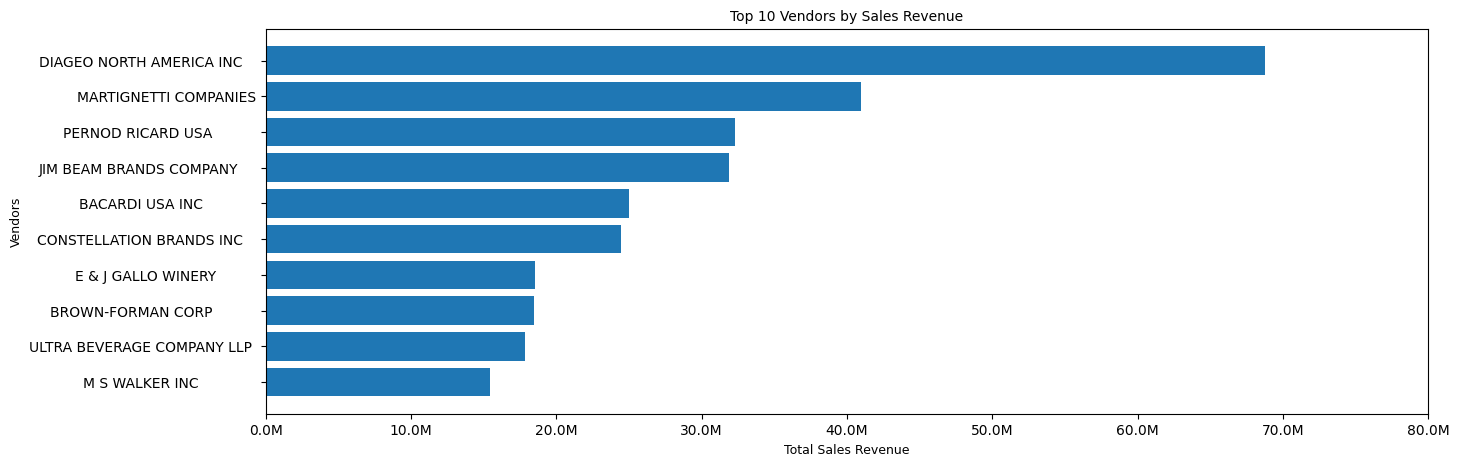

In [66]:
top_10 = top10.head(10)
plt.figure(figsize=(15,5))
plt.barh(top_10['VendorName'], top_10['TotalRevenue'])
plt.xlabel("Total Sales Revenue", fontsize = 9)
plt.ylabel("Vendors", fontsize = 9)
plt.title("Top 10 Vendors by Sales Revenue", fontsize = 10)
plt.gca().invert_yaxis()
ticks = plt.xticks()[0]
plt.xticks(ticks, [  f'{x/1000000:.1f}M' for x in ticks])
plt.show()

In [67]:
revenue_frm_top10 = round(top_10['TotalRevenue'].sum() / vendor_sales['TotalRevenue'].sum() * 100, 2)
revenue_frm_top10

64.98

##### Insights:
-  The top 10 vendors contribute a significant portion of total sales (~65%) which shows a high dependence on these vendors, which may increase business risk but it also creates an opportunity to strengthen relationships and negotiate better commercial terms with key vendors.


In [68]:
# create gross profit column
summary_df['GrossProfit'] = summary_df['TotalSalesDollars'] - summary_df['TotalPurchaseDollars']

In [69]:
# create profit margin column
summary_df['ProfitMarginPct'] = round((summary_df['GrossProfit']/summary_df['TotalSalesDollars'])*100,2 )

In [70]:
summary_df['ProfitMarginPct'] = summary_df['ProfitMarginPct'].replace([np.inf,-np.inf], np.nan) 

In [71]:
summary_df[['TotalSalesDollars', 'TotalPurchaseDollars', 'GrossProfit', 'ProfitMarginPct']].head()

,TotalSalesDollars,TotalPurchaseDollars,GrossProfit,ProfitMarginPct
0,665.82,190.88,474.94,71.33
1,599.76,5440.00,-4840.24,-807.03
2,0.00,105.07,-105.07,NaN
3,704.53,446.16,258.37,36.67
4,0.00,66.60,-66.60,NaN


In [72]:
vendor_profit = summary_df.groupby(['VendorNumber','VendorName'], as_index=False).agg(
                                                                        TotalRevenue = ('TotalSalesDollars','sum'),
                                                                        TotalProfit = ('GrossProfit','sum'))

In [73]:
top20_revenue = vendor_profit.sort_values('TotalRevenue', ascending=False).head(20)

top20_profit = vendor_profit.sort_values('TotalProfit', ascending=False).head(20)

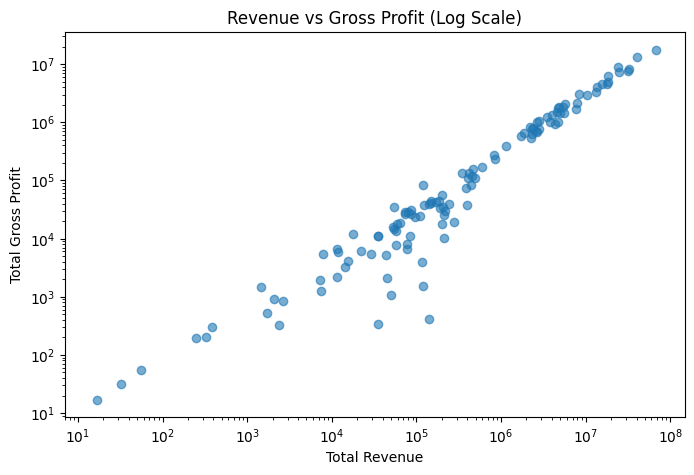

In [74]:
# since few vendors have extremely high revenue values we use log-scale to get pattern better
plt.figure(figsize=(8, 5))
plt.scatter(vendor_profit['TotalRevenue'],vendor_profit['TotalProfit'],alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Revenue')
plt.ylabel('Total Gross Profit')
plt.title('Revenue vs Gross Profit (Log Scale)')
plt.show()

##### Insights:
-  The log-scale scatter plot reveals a strong positive relationship between vendor revenue and gross profit, indicating that higher sales generally translate into higher profitability

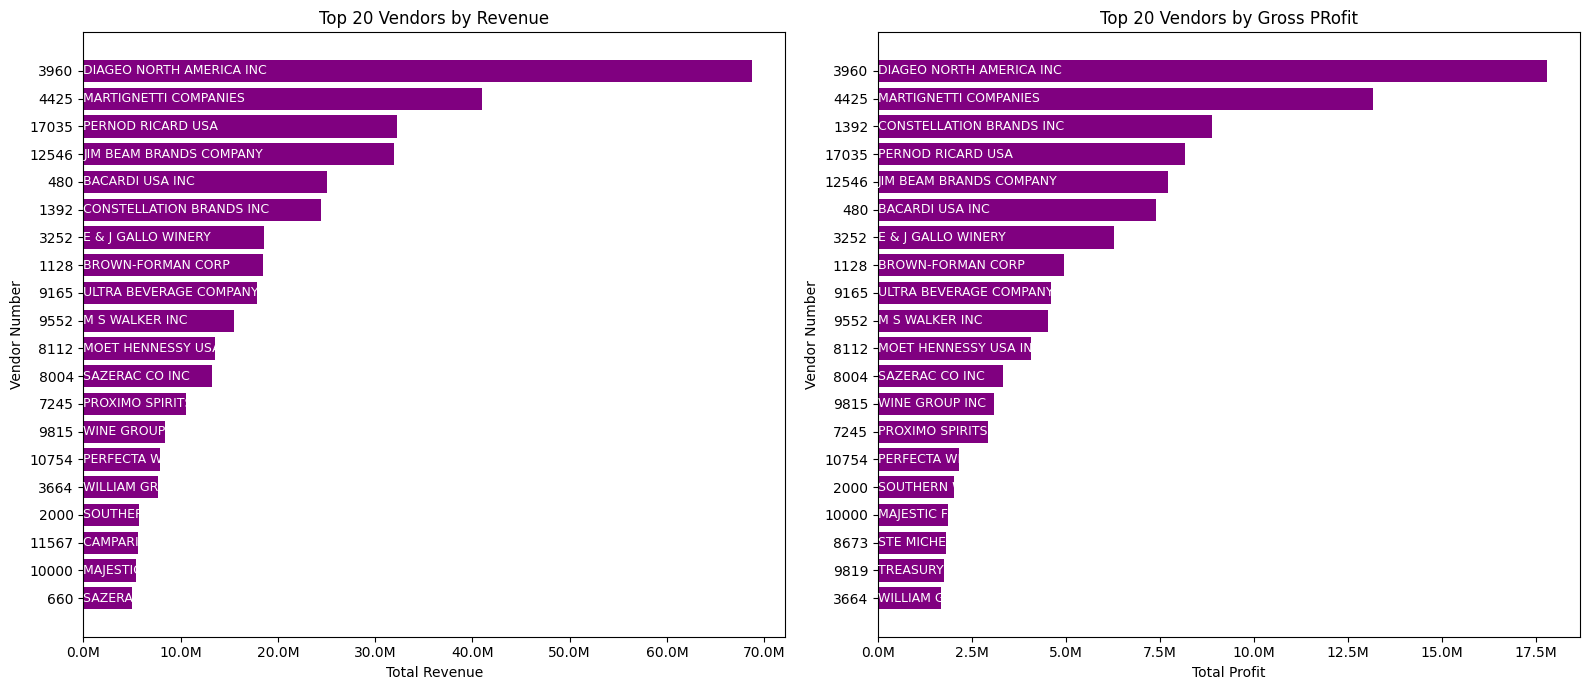

In [75]:
fig, axes = plt.subplots(1,2,figsize = (16,7))

axes[0].barh(top20_revenue['VendorNumber'].astype(str), top20_revenue['TotalRevenue'], color ='purple')
axes[0].invert_yaxis()
for i, value in enumerate(top20_revenue['TotalRevenue']):
    axes[0].text(0, i, f"{top20_revenue['VendorName'].iloc[i]}", ha='left', fontsize = 9, color='white', va='center')
axes[0].set_title('Top 20 Vendors by Revenue')
axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1_000_000:.1f}M'))
axes[0].set_xlabel('Total Revenue')
axes[0].set_ylabel('Vendor Number')

axes[1].barh(top20_profit['VendorNumber'].astype(str), top20_profit['TotalProfit'], color ='purple')
axes[1].invert_yaxis()
for i, value in enumerate(top20_profit['TotalProfit']):
    axes[1].text(0, i, f"{top20_profit['VendorName'].iloc[i]}", ha='left', fontsize = 9, color='white', va='center')
axes[1].set_title('Top 20 Vendors by Gross PRofit')
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1_000_000:.1f}M'))
axes[1].set_xlabel('Total Profit')
axes[1].set_ylabel('Vendor Number')

plt.tight_layout()
plt.show()

##### Insight 
-  The top revenue and top profit vendor lists largely overlaps, this indicates that the company's profitability is driven by this small, consistent group of vendors.
-  DIAGEO North America Inc dominates both in high revenue and profit compared to other vendors, its dominance may skew our analyses thus we can flag it in future analysis.

In [76]:
# analyse vendors with low sales but good profit margin
lowS_highP_df = summary_df[(summary_df['TotalSalesDollars'] >0) & (summary_df['ProfitMarginPct'].between(-100,200)) & 
                           (summary_df['TotalPurchaseDollars'] > 0)].copy()                                  # keep only vendors where profit margin is meaningful and to get a proper median value
sales_cap = lowS_highP_df['TotalSalesDollars'].quantile(0.75)
lowS_highP_df = lowS_highP_df[lowS_highP_df['TotalSalesDollars']<=sales_cap]

In [77]:
sales_median = lowS_highP_df['TotalSalesDollars'].median()
margin_median = lowS_highP_df['ProfitMarginPct'].median()

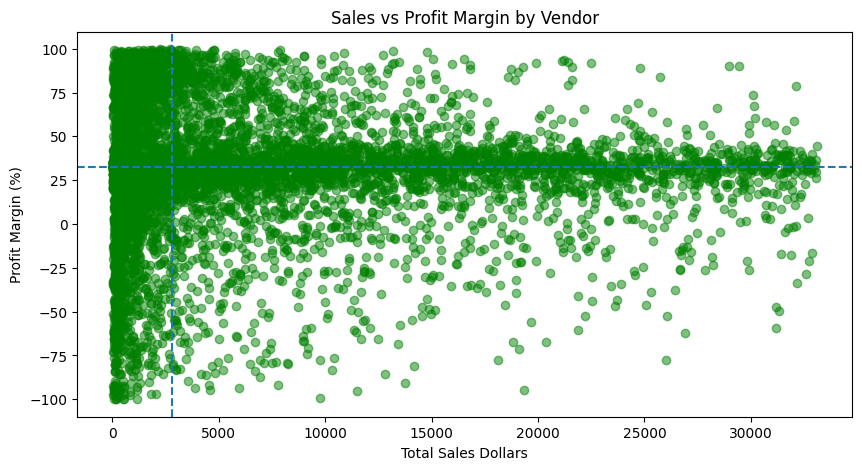

In [78]:
plt.figure(figsize =(10,5))
plt.scatter(lowS_highP_df['TotalSalesDollars'],lowS_highP_df['ProfitMarginPct'], alpha = 0.5, color ='green')
plt.axvline(sales_median,linestyle='--')
plt.axhline(margin_median,linestyle='--')
plt.xlabel('Total Sales Dollars')
plt.ylabel('Profit Margin (%)')
plt.title('Sales vs Profit Margin by Vendor')
plt.show()

##### Insights:
-  from the scatter plot we can visually confirm that there are many vendors on the left side meaning low sales but still with high profit margin. This indicates that profitability is not limited to high volume vendors and that efficient vendors exist in our dataset.
-  Of all the vendors we want to see the ones with smaller than average sales yet still more profitable, these are the ones that are above our median values. These are the ones to traget for growth.

In [79]:
Abv_average = lowS_highP_df[(lowS_highP_df['TotalSalesDollars'] < lowS_highP_df['TotalSalesDollars'].median()) 
                            &(lowS_highP_df['ProfitMarginPct'] > lowS_highP_df['ProfitMarginPct'].median())].sort_values('ProfitMarginPct', ascending=False)

In [80]:
Abv_average[['VendorNumber', 'VendorName', 'TotalSalesDollars', 'ProfitMarginPct']].head(10)

,VendorNumber,VendorName,TotalSalesDollars,ProfitMarginPct
4839,6213,MHW LTD,2717.55,99.72
6720,9165,ULTRA BEVERAGE COMPANY LLP,2221.29,99.60
9708,12546,JIM BEAM BRANDS COMPANY,2368.42,99.54
4664,4692,KOBRAND CORPORATION,1208.90,99.39
7612,9552,M S WALKER INC,1440.97,99.35
5577,7245,PROXIMO SPIRITS INC.,85.14,99.17
3272,4425,MARTIGNETTI COMPANIES,2735.24,99.12
3562,4425,MARTIGNETTI COMPANIES,2729.22,99.12
6820,9165,ULTRA BEVERAGE COMPANY LLP,1709.86,99.09
3877,4425,MARTIGNETTI COMPANIES,1874.25,99.09


##### Insights:
-  These vendors already make good profit per unit but currently contribute little to total sales. Although these vendors currently contribute a small share of total sales, they consistently achieve higher than average profit margins. Focusing on increasing their sales volumes may help the company grow profits more efficiently than relying solely on high volume vendors.

In [81]:
# check profit margin distribution of the low and high sales vendors
low_sales_cutoff = lowS_highP_df['TotalSalesDollars'].quantile(0.25)
high_sales_cutoff = lowS_highP_df['TotalSalesDollars'].quantile(0.75)

In [82]:
low_sale_vendors = lowS_highP_df[lowS_highP_df['TotalSalesDollars'] <= low_sales_cutoff]
high_sale_vendors = lowS_highP_df[lowS_highP_df['TotalSalesDollars'] >= high_sales_cutoff]

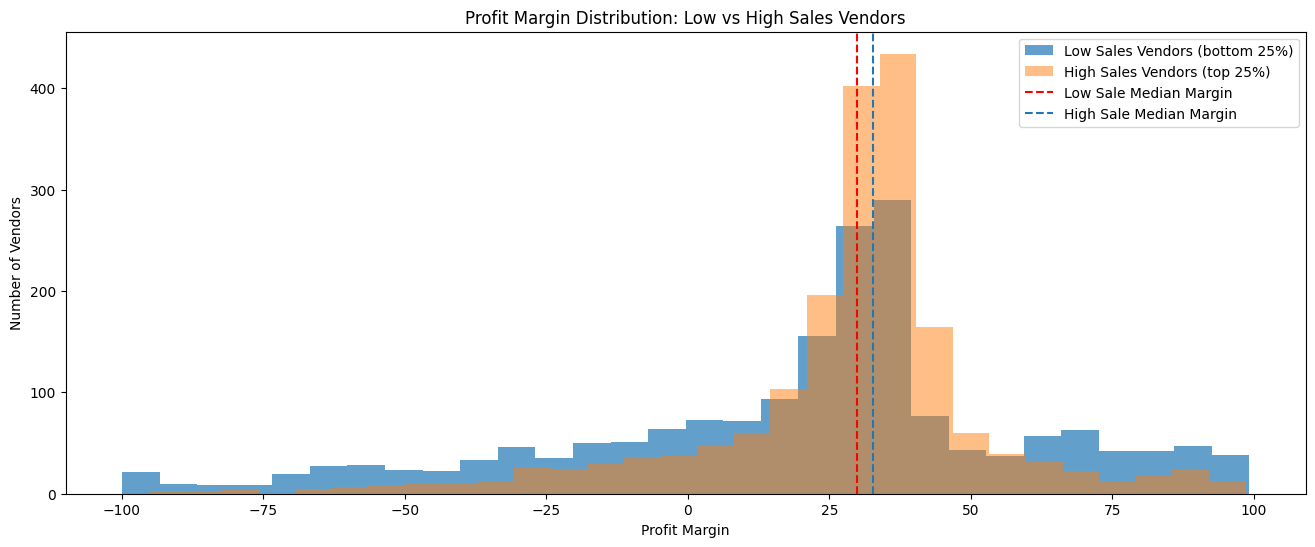

In [83]:
# plot profit margin distribution
plt.figure(figsize= (16,6))
plt.hist(low_sale_vendors['ProfitMarginPct'], bins= 30, alpha = 0.7, label= 'Low Sales Vendors (bottom 25%)')
plt.hist(high_sale_vendors['ProfitMarginPct'], bins= 30, alpha = 0.5, label= 'High Sales Vendors (top 25%)')
plt.axvline(low_sale_vendors['ProfitMarginPct'].median(), linestyle='--', label='Low Sale Median Margin',color='red')
plt.axvline(high_sale_vendors['ProfitMarginPct'].median(), linestyle='--', label='High Sale Median Margin')
plt.xlabel('Profit Margin')
plt.ylabel('Number of Vendors')
plt.title('Profit Margin Distribution: Low vs High Sales Vendors')
plt.legend()
plt.show()

##### Insights:
-  Both groups cluster around ~25-35% thus most vendors regardless of sales size operate in a similar margin band
-  Low sales vendors have a wider spread they spreads much further to the right (very high margins) but also further to the left (very negative margins)
-  High sales vendors have fewer extreme values but the median margins of both low and high are close thus we can interpret that sales volume does not automatically translate into better profitability

In [84]:
# see if revenue/profit is coming from too few vendors
vendor_profit.head()

,VendorNumber,VendorName,TotalRevenue,TotalProfit
0,2,"IRA GOLDMAN AND WILLIAMS, LLP",1265.58,-4365.30
1,54,AAPER ALCOHOL & CHEMICAL CO,0.00,-105.07
2,60,ADAMBA IMPORTS INTL INC,67576.22,-9194.03
3,105,ALTAMAR BRANDS LLC,15748.75,4042.55
4,200,AMERICAN SPIRITS EXCHANGE,1719.97,514.81


In [85]:
# sort by revenue
vendor_profit_by_revenue = vendor_profit.sort_values('TotalRevenue', ascending = False)
vendor_profit_by_revenue.head()

,VendorNumber,VendorName,TotalRevenue,TotalProfit
43,3960,DIAGEO NORTH AMERICA INC,68744474.57,17784677.72
45,4425,MARTIGNETTI COMPANIES,40992895.73,13171421.82
104,17035,PERNOD RICARD USA,32281247.95,8157156.39
100,12546,JIM BEAM BRANDS COMPANY,31906320.54,7703259.58
7,480,BACARDI USA INC,25014556.89,7390178.17


In [86]:
total_revenue = vendor_profit_by_revenue['TotalRevenue'].sum()

In [87]:
total_revenue

452066010.99

In [88]:
top10_revenue = vendor_profit_by_revenue.head(10)['TotalRevenue'].sum()
top10_pct = (top10_revenue / total_revenue) * 100
top10_pct

64.97540219994498

- This shows high dependency on just few vendors

In [89]:
# revenue share of each vendor
vendor_profit_by_revenue['RevenueSharePct'] = (vendor_profit_by_revenue['TotalRevenue'] / total_revenue * 100)

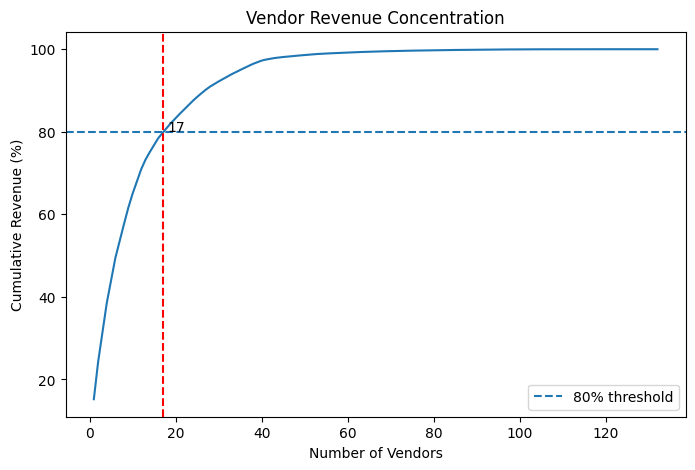

In [90]:
# see how many vendors needed to reach 80% of the revenue
vendor_profit_by_revenue['CumulativeRevenuePct'] = (vendor_profit_by_revenue['RevenueSharePct'].cumsum())  # calculate running total

plt.figure(figsize=(8,5))
plt.plot(range(1, len(vendor_profit_by_revenue) + 1),vendor_profit_by_revenue['CumulativeRevenuePct'])
plt.axhline(80, linestyle='--', label='80% threshold')
vendors_at_80 = (vendor_profit_by_revenue['CumulativeRevenuePct'] <= 80).sum() 
plt.axvline(vendors_at_80, linestyle='--', color='red')
plt.text(vendors_at_80 + 1, 80,f'{vendors_at_80}',color='black')
plt.xlabel('Number of Vendors')
plt.ylabel('Cumulative Revenue (%)')
plt.title('Vendor Revenue Concentration')
plt.legend()
plt.show()

##### Insights:
-  The cumulative revenue curve shows that approximately 80% of total revenue is generated by just ~17 vendors thus this shows company is heavily dependent on a small set of vendors and the vendors portfolio is not much diversified

In [91]:
summary_df.head(2)

,VendorNumber,VendorName,Brand,Description,TotalPurchaseQuantity,TotalPurchaseDollars,AvgPurchasePrice,PurchaseFrequency,TotalSalesQuantity,TotalSalesDollars,AvgSalesPrice,BeginInventoryQty,EndInventoryQty,GrossProfit,ProfitMarginPct
0,2,"IRA GOLDMAN AND WILLIAMS, LLP",90085,Ch Lilian 09 Ladouys St Este,8.0,190.88,23.86,3.0,18.0,665.82,36.99,16.0,6.0,474.94,71.33
1,2,"IRA GOLDMAN AND WILLIAMS, LLP",90609,Flavor Essence Variety 5 Pak,320.0,5440.00,17.00,1.0,24.0,599.76,24.99,0.0,238.0,-4840.24,-807.03


In [92]:
summary_df['AvgInventoryQty'] = (summary_df['BeginInventoryQty'] + summary_df['EndInventoryQty'] )/2

In [93]:
summary_df['InventoryTurnover'] = (summary_df['TotalPurchaseDollars'] /summary_df['AvgInventoryQty'])

In [94]:
summary_df.loc[summary_df['AvgInventoryQty'] == 0,'InventoryTurnover'] = np.nan

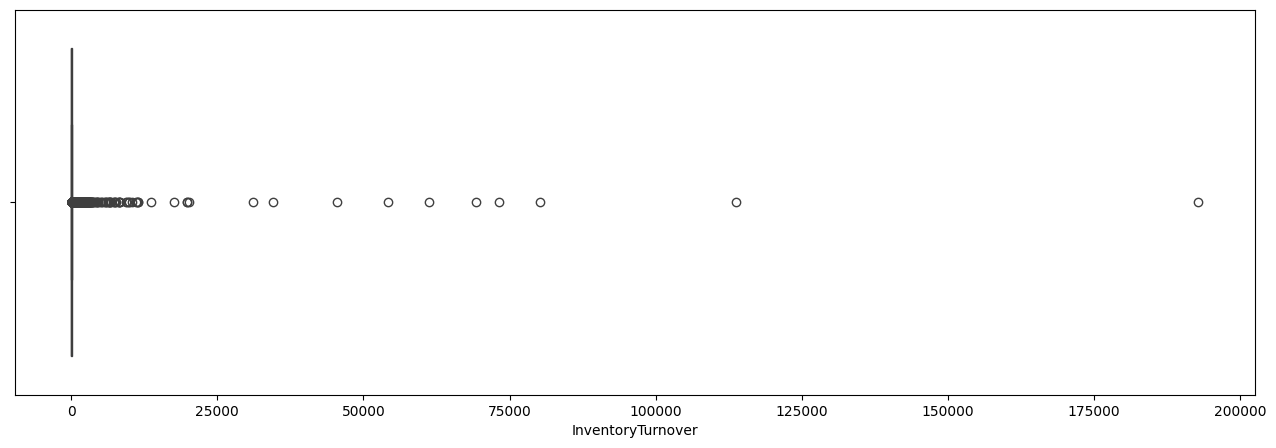

In [95]:
plt.figure(figsize=(16,5))
sns.boxplot(x= summary_df['InventoryTurnover'], data = summary_df)
plt.show()

In [96]:
summary_df['InventoryTurnover'].describe()

count     10674.000000
mean        196.198748
std        2766.030654
min           0.000000
25%          17.552500
50%          41.976589
75%          86.910000
max      192874.500000
Name: InventoryTurnover, dtype: float64

In [97]:
# cap turnover at the 99th percentile for comparative analysis
turnover_df = summary_df[(summary_df['AvgInventoryQty'] > 0) & 
                         (summary_df['InventoryTurnover'] < summary_df['InventoryTurnover'].quantile(0.99))].copy()

In [98]:
# aggregate at vendor level as we need to analyze inventory turnover with sales volume to see overall vendor performance
vendor_turnover = (turnover_df.groupby(['VendorNumber', 'VendorName'], as_index=False)
                   .agg(
                       AvgInventoryTurnover=('InventoryTurnover', 'mean'),
                       TotalSales=('TotalSalesDollars', 'sum')))

In [99]:
vendor_turnover.head()

,VendorNumber,VendorName,AvgInventoryTurnover,TotalSales
0,2,"IRA GOLDMAN AND WILLIAMS, LLP",31.533506,1265.58
1,54,AAPER ALCOHOL & CHEMICAL CO,210.140000,0.00
2,60,ADAMBA IMPORTS INTL INC,99.433131,67576.22
3,105,ALTAMAR BRANDS LLC,40.378799,15388.87
4,200,AMERICAN SPIRITS EXCHANGE,41.892549,1719.97


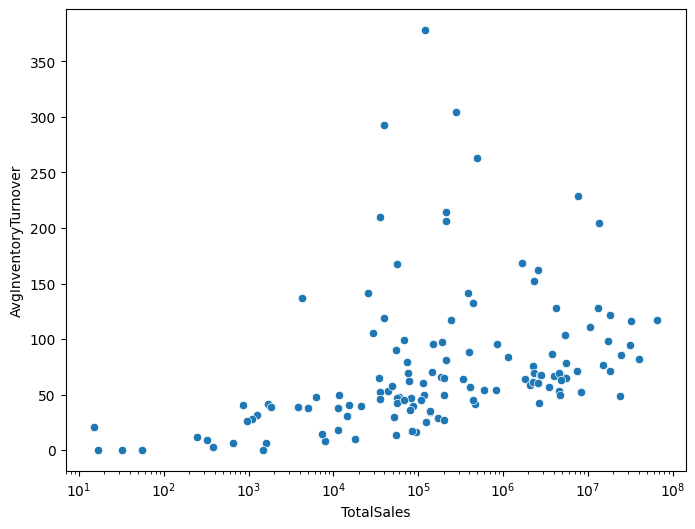

In [100]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='TotalSales', y='AvgInventoryTurnover', data = vendor_turnover)
plt.xscale('log') # since some sales have extreme values
plt.show()

-  As we can see the inventory turnrover does not increase proportionally with sales volume.
-  We need to classify vendors because we do not want to just rank them, we need vendor that rotates inventory efficiently as well as contribute to sales.

In [101]:
# data has extreme values thus get median values
turnover_median = vendor_turnover['AvgInventoryTurnover'].median()
sales_median = vendor_turnover['TotalSales'].median()

In [102]:
def classify_vendor(x):
    if x['AvgInventoryTurnover'] >= turnover_median and x['TotalSales'] >= sales_median:
        return 'Top Performer'
    elif x['AvgInventoryTurnover'] >= turnover_median and x['TotalSales'] < sales_median:
        return 'Fast Selling, Low Volume'
    elif x['AvgInventoryTurnover'] < turnover_median and x['TotalSales'] >= sales_median:
        return 'High Sales, Slow Movement'
    else:
        return 'Low Performer'

In [103]:
vendor_turnover['InvEfficiencyGrp'] = vendor_turnover.apply(classify_vendor, axis=1)

In [104]:
vendor_turnover['InvEfficiencyGrp'].value_counts()

InvEfficiencyGrp
Top Performer                50
Low Performer                49
Fast Selling, Low Volume     16
High Sales, Slow Movement    16
Name: count, dtype: int64

##### Insights:
-  Top Performer : These vendors sell quickly and generate meaningful revenue and Inventory does not sit idle
-  Low Performer: Inventory moves slowly and sales are weak
-  Fast Selling, Low Volume: These vendors sell out quickly but in small quantities maybe demand exists but supply is not much
-  High Sales, Slow Movement: These vendors sell a lot but inventory stays in stock for too long

In [105]:
efficient_vendors = (vendor_turnover[vendor_turnover['InvEfficiencyGrp'] == 'Top Performer']
                     .sort_values('TotalSales', ascending=False).head(10))

In [106]:
efficient_vendors = efficient_vendors.sort_values('AvgInventoryTurnover',ascending=False).head(10)

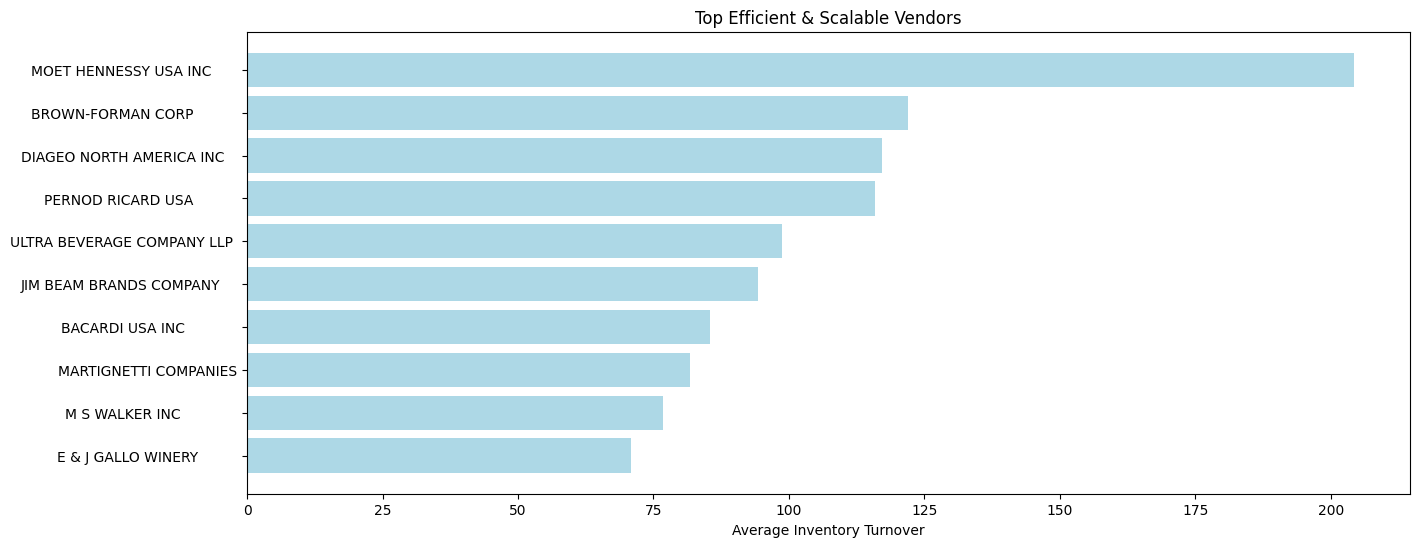

In [107]:
plt.figure(figsize=(15,6))
plt.barh(efficient_vendors['VendorName'], efficient_vendors['AvgInventoryTurnover'], color = 'lightblue')
plt.gca().invert_yaxis()
plt.xlabel('Average Inventory Turnover')
plt.title('Top Efficient & Scalable Vendors')
plt.show()

##### Insights:
-  Vendors like MOET HENNESSY USA INC, BROWN-FORMAN CORP, DIAGEO NORTH AMERICA INC etc. have high average inventory turnover. These vendors consistently convert inventory into sales without overstocking.
-  Prioritize these vendors for long-term contracts and understand their inventory strategy to apply it on others.

In [108]:
fast_sellers = (vendor_turnover[vendor_turnover['InvEfficiencyGrp'] == 'Fast Selling, Low Volume']
                     .sort_values('TotalSales', ascending=False).head(10))

In [109]:
fast_sellers = fast_sellers.sort_values('AvgInventoryTurnover',ascending=False).head(10)

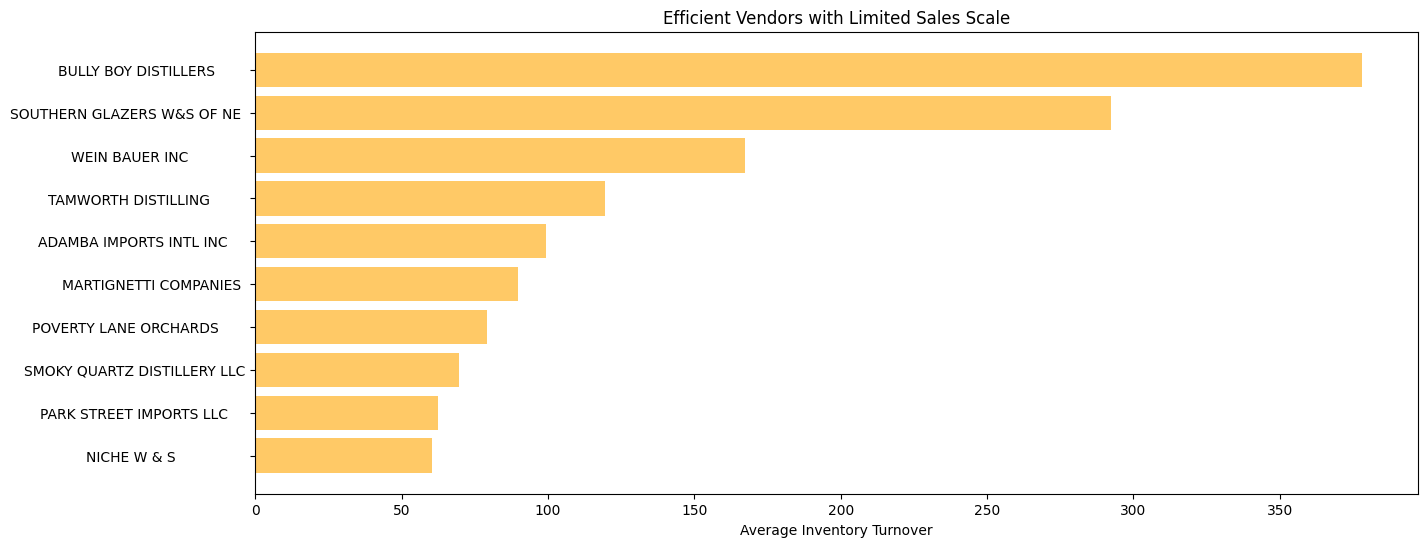

In [110]:
plt.figure(figsize=(15,6))
plt.barh(fast_sellers['VendorName'], fast_sellers['AvgInventoryTurnover'], color = 'orange', alpha=0.6)
plt.gca().invert_yaxis()
plt.xlabel('Average Inventory Turnover')
plt.title('Efficient Vendors with Limited Sales Scale')
plt.show()

##### Insights:
-  These vendors exhibit high inventory turnover, some even higher than the top performers but these vendors contribute limited sales volume. This suggests demand exists, but purchasing quantities remain small.
-  We can test these vendors with slightly higher order quantities to analyze their performance.

In [111]:
purchases.head(3)

,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2023-12-21,2024-01-02,2024-01-04,2024-02-16,35.71,6,214.26,1
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,4,37.40,1
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-02,2024-01-07,2024-02-21,9.41,5,47.05,1


In [112]:
# check if bulk purchases reduce unit cost
bulk_purchase = purchases.groupby('Brand')['Quantity'].sum().sort_values(ascending=False).head(10).index
bulk_purchase

Index([8111, 1892, 5111, 3606, 6570, 4261, 8068, 3405, 3837, 3102], dtype='int64', name='Brand')

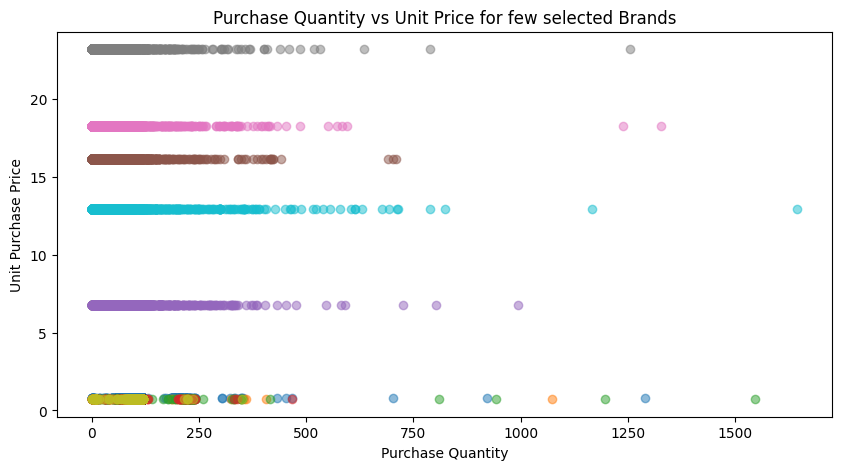

In [113]:
plt.figure(figsize = (10,5))
for b in bulk_purchase:
    fltr_row = purchases[purchases['Brand']==b]
    plt.scatter(fltr_row['Quantity'], fltr_row['PurchasePrice'], alpha = 0.5, label = f'Brand no. {b}')

plt.xlabel('Purchase Quantity')
plt.ylabel('Unit Purchase Price')
plt.title('Purchase Quantity vs Unit Price for few selected Brands')
plt.show()

##### Insights:
-  as we see although purchase quantities vary across orders for these brands, unit purchase prices remains largely consistent for the same vendor brand combinations. This indicates that bulk purchasing does not result in significant unit cost reductions, suggesting fixed pricing structures rather than volume based discounts.

In [114]:
summary_df.head(2)

,VendorNumber,VendorName,Brand,Description,TotalPurchaseQuantity,TotalPurchaseDollars,AvgPurchasePrice,PurchaseFrequency,TotalSalesQuantity,TotalSalesDollars,AvgSalesPrice,BeginInventoryQty,EndInventoryQty,GrossProfit,ProfitMarginPct,AvgInventoryQty,InventoryTurnover
0,2,"IRA GOLDMAN AND WILLIAMS, LLP",90085,Ch Lilian 09 Ladouys St Este,8.0,190.88,23.86,3.0,18.0,665.82,36.99,16.0,6.0,474.94,71.33,11.0,17.352727
1,2,"IRA GOLDMAN AND WILLIAMS, LLP",90609,Flavor Essence Variety 5 Pak,320.0,5440.00,17.00,1.0,24.0,599.76,24.99,0.0,238.0,-4840.24,-807.03,119.0,45.714286


In [115]:
# vendors that have most purchase freqency
vendor_level_purchases = (summary_df.groupby(['VendorNumber', 'VendorName'], as_index=False)
                          .agg(TotalPurchaseQty=('TotalPurchaseQuantity', 'sum'),
                               AvgPurchasePrice=('AvgPurchasePrice', 'median'),
                               PurchaseFrequency=('PurchaseFrequency', 'sum'),
                               TotalSales=('TotalSalesDollars', 'sum')))
vendor_level_purchases.head()

,VendorNumber,VendorName,TotalPurchaseQty,AvgPurchasePrice,PurchaseFrequency,TotalSales
0,2,"IRA GOLDMAN AND WILLIAMS, LLP",328.0,20.43,4.0,1265.58
1,54,AAPER ALCOHOL & CHEMICAL CO,1.0,105.07,1.0,0.00
2,60,ADAMBA IMPORTS INTL INC,4732.0,11.44,40.0,67576.22
3,105,ALTAMAR BRANDS LLC,332.0,29.48,42.0,15748.75
4,200,AMERICAN SPIRITS EXCHANGE,132.0,8.63,7.0,1719.97


In [116]:
# top procurement heavy vendors
top_proc_vendors = vendor_level_purchases.sort_values('PurchaseFrequency', ascending = False).head(20)

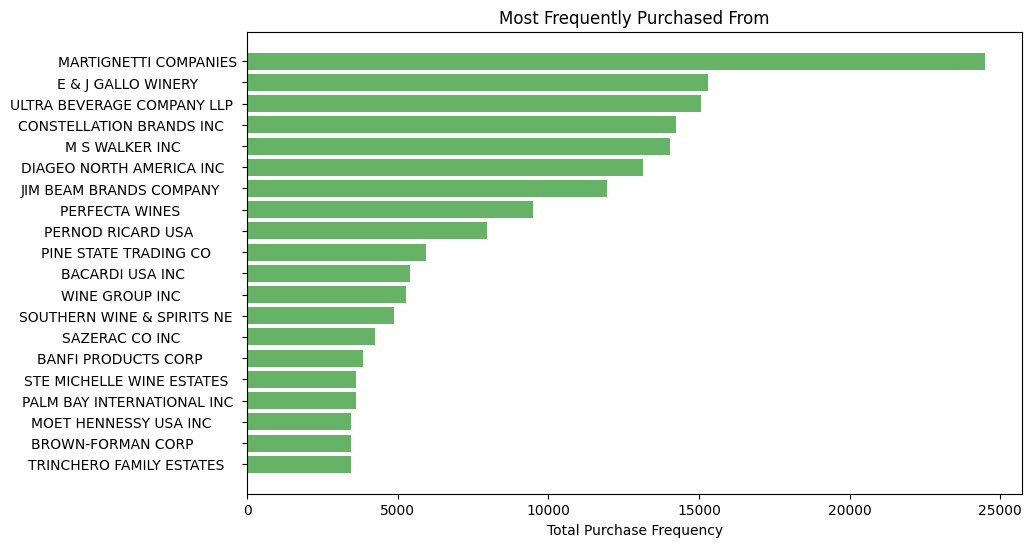

In [117]:
plt.figure(figsize=(10,6))
plt.barh(top_proc_vendors['VendorName'],top_proc_vendors['PurchaseFrequency'], color = 'green', alpha =0.6)
plt.gca().invert_yaxis()
plt.xlabel('Total Purchase Frequency')
plt.title('Most Frequently Purchased From')
plt.show()

###### Insights:
-  These small group of vendors account for a large share of procurement activity, indicating supplier dependency and potential operational risk if these disruptions or sudden discontinuation happen from these vendors.

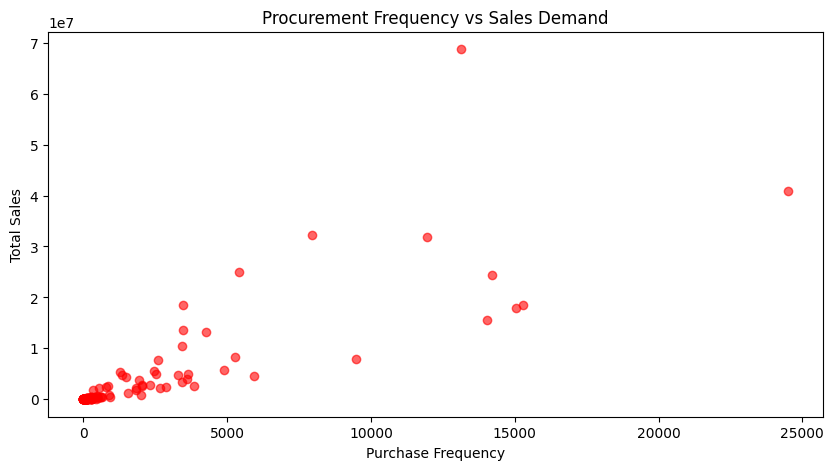

In [118]:
plt.figure(figsize=(10,5))
plt.scatter(vendor_level_purchases['PurchaseFrequency'],vendor_level_purchases['TotalSales'],alpha=0.6, color='red')
plt.xlabel('Purchase Frequency')
plt.ylabel('Total Sales')
plt.title('Procurement Frequency vs Sales Demand')
plt.show()

##### Insights:
-  The relationship between purchase frequency and sales is positive but not linear. While vendors with low purchase frequency generally generate low sales, higher purchase frequency does not consistently translate into proportionally higher sales.

In [119]:
# create sales tiers
summary_df['SalesTier'] = pd.qcut(summary_df['TotalSalesDollars'],q=4,labels=['Low Sales', 'Medium Sales', 'High Sales', 'Ultra-High Sales'])
summary_df.head(3)

,VendorNumber,VendorName,Brand,Description,TotalPurchaseQuantity,TotalPurchaseDollars,AvgPurchasePrice,PurchaseFrequency,TotalSalesQuantity,TotalSalesDollars,AvgSalesPrice,BeginInventoryQty,EndInventoryQty,GrossProfit,ProfitMarginPct,AvgInventoryQty,InventoryTurnover,SalesTier
0,2,"IRA GOLDMAN AND WILLIAMS, LLP",90085,Ch Lilian 09 Ladouys St Este,8.0,190.88,23.86,3.0,18.0,665.82,36.99,16.0,6.0,474.94,71.33,11.0,17.352727,Medium Sales
1,2,"IRA GOLDMAN AND WILLIAMS, LLP",90609,Flavor Essence Variety 5 Pak,320.0,5440.00,17.00,1.0,24.0,599.76,24.99,0.0,238.0,-4840.24,-807.03,119.0,45.714286,Medium Sales
2,54,AAPER ALCOHOL & CHEMICAL CO,990,Ethyl Alcohol 200 Proof,1.0,105.07,105.07,1.0,0.0,0.00,NaN,0.0,1.0,-105.07,NaN,0.5,210.140000,Low Sales


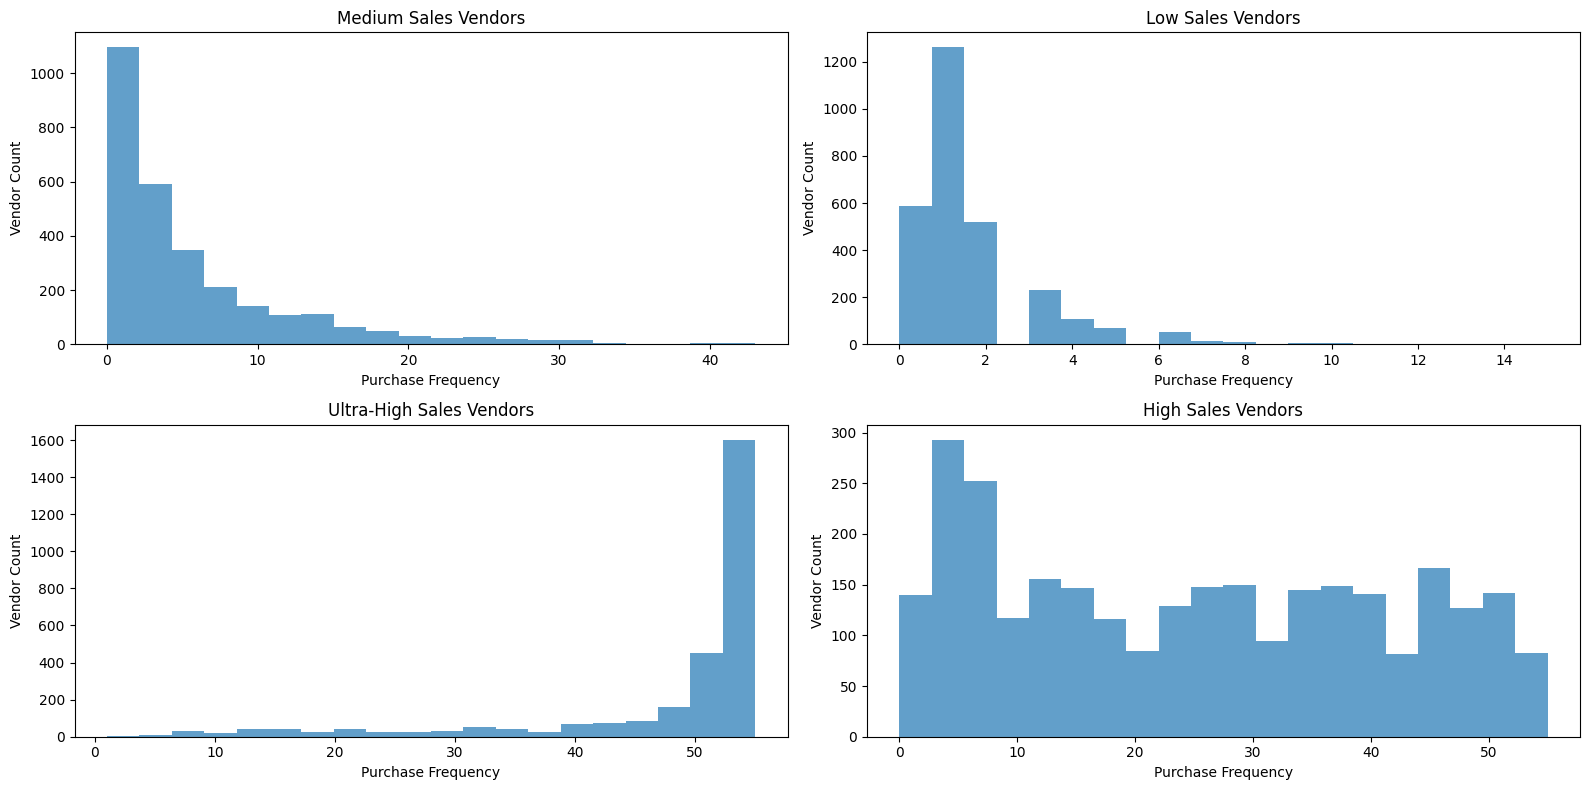

In [120]:
fig,axes = plt.subplots(2,2, figsize = (16,8))
tiers = summary_df['SalesTier'].unique()

for ax, tier in zip(axes.flatten(),tiers):
    subset = summary_df[summary_df['SalesTier']==tier]
    ax.hist(subset['PurchaseFrequency'], bins =20, alpha =0.7)
    ax.set_title(f'{tier} Vendors')
    ax.set_xlabel('Purchase Frequency')
    ax.set_ylabel('Vendor Count')
plt.tight_layout()
plt.show()

##### Insights:
-  Purchase frequency varies significantly even among vendors with similar sales levels. This suggests that sales performance is not influenced by purchasing frequency.

#### Statistical Analysis

##### Test 1 : Do we buy more from vendors whose products sell more?
H₀ (Null):Purchase frequency and sales are not related</br>
H₁ (Alternative): Vendors with higher sales tend to be purchased from more frequently

In [121]:
vendor_sales = sales.groupby(['VendorNo', 'VendorName'], as_index=False).agg(TotalSalesDollars=('SalesDollars', 'sum'))
vendor_purchases = purchases.groupby(['VendorNumber', 'VendorName'], as_index=False).agg(PurchaseFrequency=('PONumber', 'nunique'))

In [122]:
test1_df = vendor_sales.merge(vendor_purchases,left_on='VendorNo',right_on='VendorNumber',how='inner')

In [123]:
corr, p_value = spearmanr(test1_df['PurchaseFrequency'],test1_df['TotalSalesDollars'])
corr, p_value

(0.7902127352081948, 1.2149977525878465e-29)

##### Insights:
-  Spearman correlation is 0.79 which is very high, it means a strong positive relationship between vendor purchase frequency and total sales. And p-value is ~0 which means it shows statistical significance and that it is extremely unlikely that this pattern is random.
-  Thus from analysis we can see vendors with higher sales are generally purchased from much more frequently.

##### Test 2: Are high-margin vendors statistically different from others?
In EDA we saw some vendors make very good margins even though their sales are not very high. So we must check how they are different or was it just for few cases.

In [124]:
vendor_sales = (sales.groupby(['VendorNo', 'VendorName'], as_index=False).agg(TotalSales=('SalesDollars', 'sum')))
vendor_cost = (purchases.groupby(['VendorNumber', 'VendorName'], as_index=False).agg(TotalCost=('Dollars', 'sum')))

In [125]:
vendor_margin = vendor_sales.merge(vendor_cost,left_on='VendorNo',right_on='VendorNumber',how='inner')

In [126]:
vendor_margin['GrossMarginPct'] = ((vendor_margin['TotalSales'] - vendor_margin['TotalCost']) /vendor_margin['TotalSales']) * 100

In [127]:
median_margin = vendor_margin['GrossMarginPct'].median()

high_margin_vendors = vendor_margin[vendor_margin['GrossMarginPct'] > median_margin]
low_margin_vendors = vendor_margin[vendor_margin['GrossMarginPct'] <= median_margin]

In [128]:
stat, p_value = mannwhitneyu(high_margin_vendors['TotalSales'],low_margin_vendors['TotalSales'],alternative='two-sided')
stat, p_value

(2743.0, 0.01676331309785041)

-  p-value is below 0.05, so the difference we see is unlikely to be random thus there is a real, statistically meaningful difference between the two groups and high-margin vendors and low-margin vendors behave differently in terms of sales.

In [129]:
high_margin_vendors['TotalSales'].median(), low_margin_vendors['TotalSales'].median()

(535957.405, 95208.77)

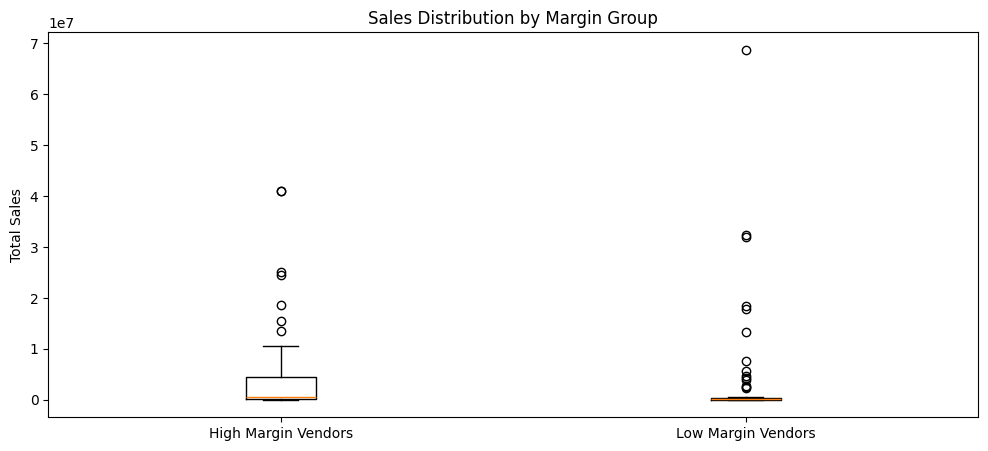

In [130]:
plt.figure(figsize=(12,5))
plt.boxplot([high_margin_vendors['TotalSales'],low_margin_vendors['TotalSales']],labels=['High Margin Vendors', 'Low Margin Vendors'])
plt.ylabel('Total Sales')
plt.title('Sales Distribution by Margin Group')
plt.show()

##### Insights: 
-  A Mann–Whitney U test confirms a statistically significant difference (p = 0.0167) in sales distributions between high-margin and low-margin vendors.
-  Vendors with higher profit margins also tend to generate higher sales.
-  This shows that the company does not have to choose between profitability and sales volume. Vendors who offer good margins while maintaining strong sales are valuable partners and should be prioritized in procurement decisions.

----------------------------------------

#### Predictive Modeling

In [132]:
sales_summary_df = sales.groupby(['VendorNo','VendorName','Brand','Volume'], as_index = False).agg( 
                                                        TotalSalesQuantity = ('SalesQuantity', 'sum'),
                                                        TotalSalesDollars = ('SalesDollars', 'sum'),
                                                        AvgSalesPrice = ('SalesPrice','mean'))
sales_summary_df = sales_summary_df.rename(columns = {'VendorNo': 'VendorNumber'})

In [133]:
purchase_summary_df = purchases.groupby(['VendorNumber','VendorName','Brand'], as_index = False).agg(
                            TotalPurchaseQuantity = ('Quantity', 'sum'),
                            TotalPurchaseDollars = ('Dollars', 'sum'),
                            AvgPurchasePrice = ('PurchasePrice','mean'),
                            PurchaseFrequency = ('PONumber','nunique'))

In [134]:
vendor_sales_summary = sales_summary_df.merge(purchase_summary_df, on = ['VendorNumber','VendorName','Brand'] , how='inner')

In [135]:
begin_inventory_summary_df = begin_inventory.groupby(['Brand'], as_index = False).agg(
                                                                                BeginInventoryQty = ('onHand','sum'))

In [136]:
vendor_sales_summary = vendor_sales_summary.merge(begin_inventory_summary_df, on = 'Brand' , how='inner')

In [137]:
end_inventory_summary_df = end_inventory.groupby(['Brand'], as_index = False).agg(
                                                                                EndInventoryQty = ('onHand','sum'))

In [138]:
vendor_sales_summary = vendor_sales_summary.merge(end_inventory_summary_df, on = 'Brand' , how='inner')

In [139]:
vendor_sales_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6665 entries, 0 to 6664
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorNumber           6665 non-null   int64  
 1   VendorName             6665 non-null   object 
 2   Brand                  6665 non-null   int64  
 3   Volume                 6665 non-null   float64
 4   TotalSalesQuantity     6665 non-null   int64  
 5   TotalSalesDollars      6665 non-null   float64
 6   AvgSalesPrice          6665 non-null   float64
 7   TotalPurchaseQuantity  6665 non-null   int64  
 8   TotalPurchaseDollars   6665 non-null   float64
 9   AvgPurchasePrice       6665 non-null   float64
 10  PurchaseFrequency      6665 non-null   int64  
 11  BeginInventoryQty      6665 non-null   int64  
 12  EndInventoryQty        6665 non-null   int64  
dtypes: float64(5), int64(7), object(1)
memory usage: 677.0+ KB


In [140]:
vendor_sales_summary = vendor_sales_summary.loc[~((vendor_sales_summary['BeginInventoryQty'] == 0) &(vendor_sales_summary['EndInventoryQty'] == 0))].copy()

In [141]:
vendor_sales_summary['VendorNumber'] = vendor_sales_summary['VendorNumber'].astype(str)
vendor_sales_summary['Brand'] = vendor_sales_summary['Brand'].astype(str)

In [142]:
vendor_sales_summary['AvgInventoryQty'] = (vendor_sales_summary['BeginInventoryQty'] +vendor_sales_summary['EndInventoryQty']) / 2

In [143]:
vendor_sales_summary['GrossProfit'] = (vendor_sales_summary['TotalSalesDollars'] -vendor_sales_summary['TotalPurchaseDollars'])
vendor_sales_summary['ProfitMarginPct'] = (vendor_sales_summary['GrossProfit'] /vendor_sales_summary['TotalSalesDollars']) * 100

In [144]:
vendor_sales_summary['InventoryTurnoverUnits'] = (vendor_sales_summary['TotalPurchaseQuantity'] /vendor_sales_summary['AvgInventoryQty'])

In [145]:
median_margin = vendor_sales_summary['ProfitMarginPct'].median()

vendor_sales_summary['HighMarginFlag'] = (vendor_sales_summary['ProfitMarginPct'] > median_margin).astype(int)

In [146]:
vendor_sales_summary.reset_index(drop = True,inplace =True)

In [147]:
vendor_sales_summary.head(3)

,VendorNumber,VendorName,Brand,Volume,TotalSalesQuantity,TotalSalesDollars,AvgSalesPrice,TotalPurchaseQuantity,TotalPurchaseDollars,AvgPurchasePrice,PurchaseFrequency,BeginInventoryQty,EndInventoryQty,AvgInventoryQty,GrossProfit,ProfitMarginPct,InventoryTurnoverUnits,HighMarginFlag
0,2,"IRA GOLDMAN AND WILLIAMS, LLP",90085,750.0,18,665.82,36.99,8,190.88,23.86,3,16,6,11.0,474.94,71.331591,0.727273,1
1,60,ADAMBA IMPORTS INTL INC,771,750.0,47,704.53,14.99,39,446.16,11.44,4,10,2,6.0,258.37,36.672675,6.500000,1
2,105,ALTAMAR BRANDS LLC,8412,750.0,307,15346.93,49.99,320,11427.20,35.71,40,135,148,141.5,3919.73,25.540808,2.261484,0


In [148]:
vendor_sales_summary.dtypes

VendorNumber               object
VendorName                 object
Brand                      object
Volume                    float64
TotalSalesQuantity          int64
TotalSalesDollars         float64
AvgSalesPrice             float64
TotalPurchaseQuantity       int64
TotalPurchaseDollars      float64
AvgPurchasePrice          float64
PurchaseFrequency           int64
BeginInventoryQty           int64
EndInventoryQty             int64
AvgInventoryQty           float64
GrossProfit               float64
ProfitMarginPct           float64
InventoryTurnoverUnits    float64
HighMarginFlag              int32
dtype: object

In [149]:
features = ['Volume','TotalSalesQuantity','TotalSalesDollars','AvgSalesPrice','TotalPurchaseQuantity','TotalPurchaseDollars',
            'AvgPurchasePrice','PurchaseFrequency','AvgInventoryQty','InventoryTurnoverUnits']

X = vendor_sales_summary[features]
y = vendor_sales_summary['HighMarginFlag']

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42,stratify=y)

In [151]:
rf_clf = RandomForestClassifier(n_estimators=300,max_depth=8,min_samples_leaf=20,random_state=42)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=20, n_estimators=300,
                       random_state=42)

In [152]:
y_pred = rf_clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.85      0.80       667
           1       0.83      0.72      0.77       666

    accuracy                           0.79      1333
   macro avg       0.79      0.79      0.78      1333
weighted avg       0.79      0.79      0.78      1333



##### Insights:
-  model was built to identify high-margin vs low-margin vendors using sales, purchasing, and inventory features. The model achieved an overall accuracy of 79%, with strong precision for high-margin vendors (83%) and high recall for low-margin vendors (85%). This indicates the model is particularly effective at identifying underperforming vendors while reliably flagging high-margin opportunities.

In [153]:
feature_importance = pd.DataFrame({'Feature': features,'Importance': rf_clf.feature_importances_}).sort_values(by='Importance', ascending=False)

feature_importance

,Feature,Importance
9,InventoryTurnoverUnits,0.280517
6,AvgPurchasePrice,0.146826
5,TotalPurchaseDollars,0.103589
4,TotalPurchaseQuantity,0.103540
3,AvgSalesPrice,0.088039
2,TotalSalesDollars,0.082683
1,TotalSalesQuantity,0.072701
8,AvgInventoryQty,0.062765
0,Volume,0.033637
7,PurchaseFrequency,0.025703


##### Insights:
-  Top 3 drivers of profitability are:
-  InventoryTurnoverUnits, AvgPurchasePrice & TotalPurchaseDollars, this means buying behavior influences margins, also vendors whose products move faster, sell quickly relative to inventory are far more likely to be profitable.

----------------------------------------------------------

##### vendor segmentation framework for Excel

In [154]:
sales_median = vendor_sales_summary['TotalSalesDollars'].median()
median_margin = vendor_sales_summary['ProfitMarginPct'].median()

high_margin_vendors = vendor_sales_summary[vendor_sales_summary['ProfitMarginPct'] > median_margin]
low_margin_vendors = vendor_sales_summary[vendor_sales_summary['ProfitMarginPct'] <= median_margin]

High_S_High_P = high_margin_vendors[high_margin_vendors['TotalSalesDollars']>sales_median].sort_values('ProfitMarginPct', ascending =False) 
Low_S_High_P = high_margin_vendors[high_margin_vendors['TotalSalesDollars']<sales_median].sort_values('ProfitMarginPct', ascending =False) 
High_S_Low_P = low_margin_vendors[low_margin_vendors['TotalSalesDollars']>sales_median].sort_values('ProfitMarginPct', ascending =False) 
Low_S_Low_P = low_margin_vendors[low_margin_vendors['TotalSalesDollars']<sales_median].sort_values('ProfitMarginPct', ascending =False)

In [155]:
High_S_High_P.to_csv("High_S_High_P.csv", index = False)
Low_S_High_P.to_csv("Low_S_High_P.csv", index = False)
High_S_Low_P.to_csv("High_S_Low_P.csv", index = False)
Low_S_Low_P.to_csv("Low_S_Low_P.csv", index = False)